In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import os
from PIL import Image
warnings.filterwarnings('ignore')

In [2]:
# Matplotlib configuration
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [5]:
class CatDataset(Dataset):
    """
    Dataset personalizado para cargar imágenes de gatos.
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        # Return image and a dummy label (0 for cats)
        return image, 0

In [6]:
def load_cat_dataset():
    """
    Carga y prepara el dataset de gatos para entrenamiento.
    
    Returns:
        train_loader, val_loader: DataLoaders para entrenamiento y validación
    """
    print("Cargando dataset de gatos...")
    
    # Transformaciones: redimensionar a 64x64, convertir a tensor, normalizar
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Redimensionar a 64x64
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizar a [-1, 1]
    ])
    
    # Cargar dataset de gatos
    cat_train_dir = './data/cats_dogs_mini/train/cat'
    cat_val_dir = './data/cats_dogs_mini/validate/cat'
    
    # Verificar que existen los directorios
    if not os.path.exists(cat_train_dir):
        print(f"Error: No se encontró el directorio de entrenamiento: {cat_train_dir}")
        return None, None
    
    train_dataset = CatDataset(cat_train_dir, transform=transform)
    
    # Si existe el directorio de validación, usarlo; si no, dividir el de entrenamiento
    if os.path.exists(cat_val_dir):
        val_dataset = CatDataset(cat_val_dir, transform=transform)
    else:
        # Dividir el dataset de entrenamiento en train/val
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
    
    # Crear dataloaders
    batch_size = 32  # Batch size más pequeño para imágenes más grandes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Conjunto de entrenamiento: {len(train_dataset)} imágenes")
    print(f"Conjunto de validación: {len(val_dataset)} imágenes")
    print(f"Batch size: {batch_size}")
    print(f"Dimensiones de imagen: 64x64x3 (RGB)")
    
    return train_loader, val_loader

In [7]:
def show_dataset_examples(train_loader):
    """
    Visualiza algunas imágenes del dataset de gatos.
    
    Args:
        train_loader: DataLoader para el conjunto de entrenamiento
    """
    print("Mostrando ejemplos del dataset...")
    
    # Obtener un batch de datos
    dataiter = iter(train_loader)
    images, labels = next(dataiter)
    
    # Desnormalizar imágenes de [-1, 1] a [0, 1]
    images = (images + 1) / 2
    
    # Mostrar algunas imágenes
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    for i in range(8):
        row, col = i // 4, i % 4
        img = images[i].permute(1, 2, 0).cpu().numpy()  # Cambiar de (C, H, W) a (H, W, C)
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Gato {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Ejemplos del Dataset de Gatos', fontsize=16)
    plt.tight_layout()
    plt.show()

In [8]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) para imágenes de gatos.
    
    El VAE consiste en:
    1. Encoder: Mapea imágenes a parámetros de distribución latente (μ, σ)
    2. Reparameterización: Muestrea del espacio latente usando el truco de reparameterización
    3. Decoder: Reconstruye imágenes desde el espacio latente
    """
    
    def __init__(self, input_channels=3, image_size=64, hidden_dim=512, latent_dim=128):
        """
        Inicializa el VAE.
        
        Args:
            input_channels: Número de canales de entrada (3 para RGB)
            image_size: Tamaño de la imagen (64x64)
            hidden_dim: Dimensión de la capa oculta
            latent_dim: Dimensión del espacio latente
        """
        super(VAE, self).__init__()
        
        self.input_channels = input_channels
        self.image_size = image_size
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Calcular dimensiones después de las capas convolucionales
        self.conv_output_size = image_size // 4  # Después de 2 maxpool
        self.conv_output_dim = 128 * self.conv_output_size * self.conv_output_size
        
        # Encoder: Imagen -> Parámetros de distribución latente
        self.encoder = nn.Sequential(
            # Primera capa convolucional
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Segunda capa convolucional
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            # Tercera capa convolucional
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        
        # Capas para producir μ y log(σ²) para el espacio latente
        self.fc_mu = nn.Linear(self.conv_output_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.conv_output_dim, latent_dim)
        
        # Decoder: Espacio latente -> Imagen reconstruida
        self.decoder = nn.Sequential(
            # Primera capa lineal
            nn.Linear(latent_dim, self.conv_output_dim),
            nn.ReLU(),
            
            # Primera capa deconvolucional
            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            # Segunda capa deconvolucional
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            
            # Capa final
            nn.Conv2d(64, input_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()  # Salida en [-1, 1] para coincidir con la normalización
        )
    
    def encode(self, x):
        """
        Codifica la entrada x en parámetros de distribución latente.
        
        Args:
            x: Tensor de entrada (batch_size, channels, height, width)
            
        Returns:
            mu, logvar: Parámetros de distribución latente
        """
        h = self.encoder(x)
        h = h.view(h.size(0), -1)  # Aplanar
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparametrize(self, mu, logvar):
        """
        Implementa el truco de reparameterización para muestreo diferenciable.
        
        Args:
            mu: Media de la distribución latente
            logvar: Log varianza de la distribución latente
            
        Returns:
            z: Muestra del espacio latente
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + eps * std
        else:
            z = mu
        return z
    
    def decode(self, z):
        """
        Decodifica el vector latente z en una imagen reconstruida.
        
        Args:
            z: Vector del espacio latente
            
        Returns:
            x_recon: Imagen reconstruida
        """
        h = self.decoder[0](z)  # Primera capa lineal
        h = h.view(h.size(0), 128, self.conv_output_size, self.conv_output_size)
        x_recon = self.decoder[1:](h)  # Resto de capas convolucionales
        return x_recon
    
    def forward(self, x):
        """
        Pase completo hacia adelante del VAE.
        
        Args:
            x: Tensor de entrada (batch_size, channels, height, width)
            
        Returns:
            x_recon, mu, logvar: Imagen reconstruida y parámetros latentes
        """
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [9]:
def vae_loss(x_recon, x, mu, logvar, beta=1.0):
    """
    Calcula la función de pérdida del VAE.
    
    Pérdida total: L = L_reconstrucción + β * L_KL
    
    Args:
        x_recon: Imagen reconstruida
        x: Imagen original
        mu: Media latente
        logvar: Log varianza latente
        beta: Peso para el término KL (β-VAE)
        
    Returns:
        loss: Pérdida total
        recon_loss: Pérdida de reconstrucción
        kl_loss: Pérdida KL
    """
    # Pérdida de reconstrucción (MSE para imágenes RGB)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    
    # Pérdida KL: D_KL(N(μ, σ²) || N(0, I))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    total_loss = recon_loss + beta * kl_loss
    return total_loss, recon_loss, kl_loss

In [10]:
def train_vae(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    """
    Entrena el modelo VAE.
    
    Args:
        model: Modelo VAE
        train_loader: DataLoader de entrenamiento
        val_loader: DataLoader de validación
        num_epochs: Número de épocas de entrenamiento
        lr: Tasa de aprendizaje
        
    Returns:
        train_losses: Lista de pérdidas de entrenamiento por época
        val_losses: Lista de pérdidas de validación por época
    """
    print(f"Iniciando entrenamiento VAE por {num_epochs} épocas...")
    
    optimizer = optim.Adam(model.parameters(), lr=lr)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        total_recon_loss = 0
        total_kl_loss = 0
        
        pbar = tqdm(train_loader, desc=f'Época {epoch+1}/{num_epochs}')
        
        for batch_idx, (data, _) in enumerate(pbar):
            data = data.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            
            pbar.set_postfix({
                'Loss': f'{loss.item():.2f}',
                'Recon': f'{recon_loss.item():.2f}',
                'KL': f'{kl_loss.item():.2f}'
            })
        
        # Calcular pérdidas promedio
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_recon_loss = total_recon_loss / len(train_loader.dataset)
        avg_kl_loss = total_kl_loss / len(train_loader.dataset)
        
        train_losses.append(avg_train_loss)
        
        # Evaluación en conjunto de validación
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for data, _ in val_loader:
                data = data.to(device)
                recon_batch, mu, logvar = model(data)
                loss, _, _ = vae_loss(recon_batch, data, mu, logvar)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)
        
        print(f'Época {epoch+1}: Train Loss: {avg_train_loss:.4f}, '
              f'Recon: {avg_recon_loss:.4f}, KL: {avg_kl_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')
    
    print("Entrenamiento completado!")
    return train_losses, val_losses

In [11]:
def visualizar_reconstrucciones(model, val_loader, num_examples=8):
    """
    Visualiza las reconstrucciones del VAE.
    
    Args:
        model: Modelo VAE entrenado
        val_loader: DataLoader de validación
        num_examples: Número de ejemplos a mostrar
    """
    print("Visualizando reconstrucciones...")
    
    model.eval()
    dataiter = iter(val_loader)
    images, labels = next(dataiter)
    
    # Tomar solo los primeros num_examples
    images = images[:num_examples].to(device)
    labels = labels[:num_examples]
    
    with torch.no_grad():
        # Generar reconstrucciones
        recon_images, _, _ = model(images)
    
    # Desnormalizar imágenes de [-1, 1] a [0, 1]
    images = (images + 1) / 2
    recon_images = (recon_images + 1) / 2
    
    # Visualizar originales vs reconstrucciones
    fig, axes = plt.subplots(2, num_examples, figsize=(2*num_examples, 4))
    
    for i in range(num_examples):
        # Imagen original
        img_orig = images[i].permute(1, 2, 0).cpu().numpy()
        axes[0, i].imshow(img_orig)
        axes[0, i].set_title(f'Original: Gato {i+1}')
        axes[0, i].axis('off')
        
        # Imagen reconstruida
        img_recon = recon_images[i].permute(1, 2, 0).cpu().numpy()
        axes[1, i].imshow(img_recon)
        axes[1, i].set_title(f'Reconstruida')
        axes[1, i].axis('off')
    
    plt.suptitle('Originales vs Reconstrucciones del VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

In [12]:
def visualizar_espacio_latente(model, val_loader):
    """
    Visualiza el espacio latente del VAE usando las primeras 2 dimensiones.
    
    Args:
        model: Modelo VAE entrenado
        val_loader: DataLoader de validación
    """
    print("Visualizando espacio latente...")
    
    model.eval()
    latents = []
    labels = []
    
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latents.append(mu.cpu())
            labels.append(target)
    
    # Concatenar todos los vectores latentes
    latents = torch.cat(latents, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    # Visualizar las primeras 2 dimensiones del espacio latente
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Gato')
    plt.xlabel('Dimensión Latente 1')
    plt.ylabel('Dimensión Latente 2')
    plt.title('Visualización del Espacio Latente del VAE (Primeras 2 Dimensiones)')
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
def generar_imagenes(model, num_images=16):
    """
    Genera nuevas imágenes muestreando del espacio latente.
    
    Args:
        model: Modelo VAE entrenado
        num_images: Número de imágenes a generar
    """
    print(f"Generando {num_images} nuevas imágenes...")
    
    model.eval()
    
    with torch.no_grad():
        # Muestrear del espacio latente (distribución normal estándar)
        z = torch.randn(num_images, model.latent_dim).to(device)
        
        # Decodificar para generar imágenes
        generated_images = model.decode(z)
        generated_images = (generated_images + 1) / 2  # Desnormalizar
    
    # Visualizar imágenes generadas
    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    for i in range(num_images):
        row, col = i // 4, i % 4
        img = generated_images[i].permute(1, 2, 0).cpu().numpy()
        axes[row, col].imshow(img)
        axes[row, col].set_title(f'Gato Generado {i+1}')
        axes[row, col].axis('off')
    
    plt.suptitle('Imágenes de Gatos Generadas por el VAE', fontsize=16)
    plt.tight_layout()
    plt.show()

In [14]:
def generar_imagenes_controladas(model, num_steps=8):
    """
    Genera imágenes interpolando en el espacio latente para mostrar continuidad.
    
    Args:
        model: Modelo VAE entrenado
        num_steps: Número de pasos de interpolación
    """
    print("Generando interpolación en el espacio latente...")
    
    model.eval()
    
    with torch.no_grad():
        # Crear dos puntos en el espacio latente
        z1 = torch.randn(1, model.latent_dim).to(device)
        z2 = torch.randn(1, model.latent_dim).to(device)
        
        # Interpolar entre los dos puntos
        alphas = torch.linspace(0, 1, num_steps).to(device)
        interpolated_images = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            img = model.decode(z_interp)
            img = (img + 1) / 2  # Desnormalizar
            interpolated_images.append(img.squeeze(0))
    
    # Visualizar interpolación
    fig, axes = plt.subplots(1, num_steps, figsize=(2*num_steps, 2))
    for i, img in enumerate(interpolated_images):
        img_np = img.permute(1, 2, 0).cpu().numpy()
        axes[i].imshow(img_np)
        axes[i].set_title(f'α={i/(num_steps-1):.1f}')
        axes[i].axis('off')
    
    plt.suptitle('Interpolación en el Espacio Latente', fontsize=16)
    plt.tight_layout()
    plt.show()

In [15]:
def main():
    """
    Función principal que ejecuta todo el pipeline del VAE.
    """
    print("=" * 60)
    print("AUTOENCODER VARIACIONAL (VAE) PARA GATOS")
    print("=" * 60)
    
    # 1. Cargar dataset
    train_loader, val_loader = load_cat_dataset()
    
    if train_loader is None:
        print("Error al cargar el dataset. Verificando estructura de directorios...")
        return
    
    # 2. Visualizar dataset
    show_dataset_examples(train_loader)
    
    # 3. Crear modelo VAE
    print("\nCreando modelo VAE...")
    model = VAE(input_channels=3, image_size=64, hidden_dim=512, latent_dim=128).to(device)
    print(f"Modelo creado con {sum(p.numel() for p in model.parameters()):,} parámetros")
    
    # 4. Entrenar modelo
    train_losses, val_losses = train_vae(model, train_loader, val_loader, num_epochs=30)
    
    # 5. Visualizar pérdidas de entrenamiento
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida durante el Entrenamiento')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.title('Evolución de la Pérdida (Escala Log)')
    plt.yscale('log')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Visualizar reconstrucciones
    visualizar_reconstrucciones(model, val_loader)
    
    # 7. Visualizar espacio latente
    visualizar_espacio_latente(model, val_loader)
    
    # 8. Generar nuevas imágenes
    generar_imagenes(model, num_images=16)
    
    # 9. Generar interpolación
    generar_imagenes_controladas(model, num_steps=8)
    
    print("\n" + "=" * 60)
    print("¡EXPERIMENTO COMPLETADO EXITOSAMENTE!")
    print("=" * 60)
    print("\nResumen de lo aprendido:")
    print("1. El VAE aprendió a comprimir imágenes de gatos en un espacio latente de 128 dimensiones")
    print("2. Puede reconstruir imágenes con buena calidad")
    print("3. El espacio latente es continuo y permite generar nuevas imágenes de gatos")
    print("4. La interpolación en el espacio latente produce transiciones suaves")
    print("\nAplicaciones potenciales:")
    print("- Generación de imágenes de gatos")
    print("- Compresión de datos de imágenes")
    print("- Análisis de representaciones latentes")
    print("- Transferencia de estilo en imágenes de gatos")

AUTOENCODER VARIACIONAL (VAE) PARA GATOS
Cargando dataset de gatos...
Conjunto de entrenamiento: 1000 imágenes
Conjunto de validación: 500 imágenes
Batch size: 32
Dimensiones de imagen: 64x64x3 (RGB)
Mostrando ejemplos del dataset...


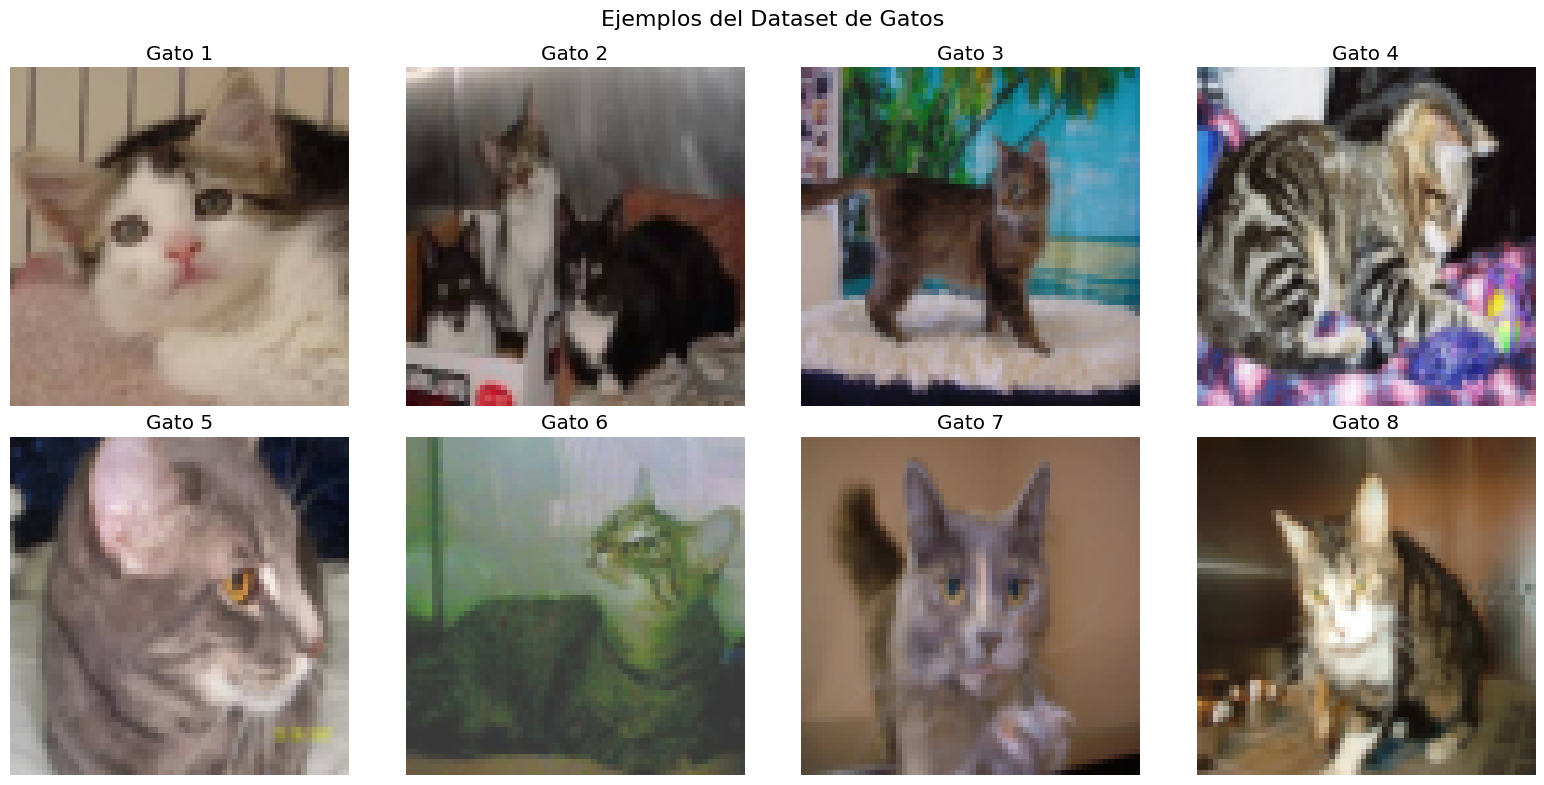


Creando modelo VAE...
Modelo creado con 13,062,275 parámetros
Iniciando entrenamiento VAE por 30 épocas...


Época 1/30: 100%|██████████| 32/32 [00:15<00:00,  2.03it/s, Loss=18995.63, Recon=18538.84, KL=456.79]   


Época 1: Train Loss: 3253.8167, Recon: 3218.3636, KL: 35.4531, Val Loss: 2780.3186


Época 2/30: 100%|██████████| 32/32 [00:15<00:00,  2.09it/s, Loss=16658.02, Recon=16264.92, KL=393.10] 


Época 2: Train Loss: 2237.5053, Recon: 2172.7840, KL: 64.7213, Val Loss: 1730.5671


Época 3/30: 100%|██████████| 32/32 [00:15<00:00,  2.11it/s, Loss=10242.22, Recon=9623.18, KL=619.04]  


Época 3: Train Loss: 1621.3789, Recon: 1544.9451, KL: 76.4338, Val Loss: 1429.7976


Época 4/30: 100%|██████████| 32/32 [00:25<00:00,  1.25it/s, Loss=8872.92, Recon=8171.24, KL=701.68]   


Época 4: Train Loss: 1395.1524, Recon: 1304.2608, KL: 90.8915, Val Loss: 1398.7058


Época 5/30: 100%|██████████| 32/32 [00:15<00:00,  2.07it/s, Loss=8370.77, Recon=7736.38, KL=634.40]   


Época 5: Train Loss: 1275.4702, Recon: 1175.0320, KL: 100.4382, Val Loss: 1236.5681


Época 6/30: 100%|██████████| 32/32 [00:15<00:00,  2.06it/s, Loss=9369.17, Recon=8560.21, KL=808.96]   


Época 6: Train Loss: 1176.7461, Recon: 1066.9667, KL: 109.7794, Val Loss: 1150.6637


Época 7/30: 100%|██████████| 32/32 [00:16<00:00,  1.98it/s, Loss=7417.57, Recon=6525.42, KL=892.15]   


Época 7: Train Loss: 1095.3276, Recon: 977.3514, KL: 117.9762, Val Loss: 1113.9266


Época 8/30: 100%|██████████| 32/32 [00:14<00:00,  2.13it/s, Loss=8740.36, Recon=7701.79, KL=1038.57]  


Época 8: Train Loss: 1051.4796, Recon: 926.5108, KL: 124.9688, Val Loss: 1072.8725


Época 9/30:  12%|█▎        | 4/32 [00:02<00:14,  1.87it/s, Loss=32057.72, Recon=27532.55, KL=4525.17]

In [ ]:
if __name__ == "__main__":
    main()